In [1]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import seaborn as sbn

setlen=lambda x:len(set(x))
def chgdir(dirname):
    """This wrapper creates a directory, if not already present, and then shifts code to that working directory."""
    if os.path.isdir(dirname):
        os.chdir(dirname)
        print('Changing directory to '+dirname)
    else:
        print('Directory '+dirname+' not found.\nCreating new directory.\nChanging to new directory.')
        os.mkdir(dirname)
        os.chdir(dirname)

cwd=os.getcwd()
cwd_input_matrices=os.path.join(cwd,'input_matrices')
cwd_genelists=os.path.join(cwd_input_matrices,'GeneLists')
cwd_res=os.path.join(cwd,'Results')

## Import Mutations burden (incidence) data from input_matrices

In [2]:
# Uncomment and run this line to skip de-novo generation of in-silico data below and speed processing along.
df_Incdstats=pd.read_csv(os.path.join(cwd_input_matrices,'df_Incdstats.csv'),sep='\t',index_col='Hugo_Symbol')
df_Incdstats=df_Incdstats.astype(float)

#Import alternate gene nomenclature file from cbioportal: https://docs.cbioportal.org/3.-cbioportal-maintenance/updating-gene-and-gene_alias-tables
#Homo_sapien.gene_info.gz ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz
dfGeneNames=pd.read_csv(os.path.join(cwd_input_matrices,'Homo_sapiens_gene_info.txt'),sep='\t')
dfGeneNames=dfGeneNames.astype(str).applymap(lambda x:x.upper())
dfGeneNames.Synonyms=[str(row).split('|') for row in dfGeneNames.Synonyms.values]
listSynonyms=[elem for row in dfGeneNames.Synonyms.values for elem in row]
def FindGeneName(igene):
    # This function has already been applied on the input gene list. In that application, care was taken to match chromosomes before deciding that two genes are same. This function therefore does not filter any names already present in the input genome matrix dfC.
    igene=igene.upper()
    retgene=igene
    if (igene in set(dfGeneNames.Symbol)) or (igene not in set(listSynonyms) or (igene in df_Incdstats.index.values)):
        return retgene
    else:
        retgene=dfGeneNames[[igene in row for row in dfGeneNames.Synonyms]].Symbol.values[0]
        return retgene

dfCT=pd.read_csv(os.path.join(cwd_genelists,'Lists_CT1and2.txt'),sep='\t') # Updated 2020 CGC,2 lists.
CGClist=set([elem for elem in dfCT['Consensus_Tier1'] if elem is not np.nan])
CGClist=[FindGeneName(igene) for igene in CGClist]

def checkindices(l1):
    """Returns TRUE if all items present in dfIncdsort else returns a list of indices absent"""
    flag=True
    listfalse=[]
    for item in l1:
        flag=flag and (item in df_Incdstats.index)
        if not (item in df_Incdstats.index):
            listfalse=listfalse+[item]
    return flag if flag else listfalse

for igene in checkindices(CGClist):
    CGClist.remove(igene)

# define a list of all CGC genes and aliases
CGCaliaslist=[]
for igene in CGClist:
    CGCaliaslist=CGCaliaslist+[igene]
    if igene in dfGeneNames.Symbol.values:
        CGCaliaslist=CGCaliaslist+dfGeneNames.Synonyms[dfGeneNames.Symbol==igene].values[0]
CGCaliaslist=list(set(CGCaliaslist))

## Import Pubs,grants data

In [3]:
df_Incd_CGC=df_Incdstats.loc[CGClist].sort_values(by='Incidence',ascending=False)

#  Input pubs and grants data
df_pubs_grants=pd.read_excel(os.path.join(cwd_input_matrices,'NIH+PM_Data.xlsx'),index_col='Gene name')
df_pubs_grants.index=[FindGeneName(idx) for idx in df_pubs_grants.index]

df_pubs_grants.rename(columns={'Pubs[title]':'Publications (#)', 'Pubs[title/abstract]':'Pubs[tiab]','Number of Grants[title/abstract]':'Grants (#)', 'Award Amount[title/abstract]':'Grants ($)'},inplace=True)

In [4]:
list_CGC_notPubs=[idx for idx in df_Incd_CGC.index if idx not in df_pubs_grants.index]
list_CGC_notPubs

['CASC5', 'WHSC1L1', 'MKL1', 'C2ORF44', 'FAM46C']

In [5]:
list_pubs_NotCGC=[idx for idx in df_pubs_grants.index if idx not in df_Incd_CGC.index]
list_pubs_NotCGC

['KNL1', 'MRTFA', 'NSD3', 'TENT5C', 'TRA', 'WDCP']

In [6]:
dropnagenes=list_pubs_NotCGC+list_CGC_notPubs
df_AllData=pd.concat([df_Incd_CGC,df_pubs_grants],axis='columns').drop(index=dropnagenes)

In [7]:
# Update global fonts for matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 25}
plt.rc('font', **font)
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}

## Supplementary Tables

In [8]:
# Output Table S1
df_AllData[['Incidence','Synonyms']].to_excel(os.path.join(cwd_res,'Tables','Table_S1_CGC_Incidence.xlsx'))

In [9]:
# Output Table S2
df_AllData[['Publications (#)','Pubs[tiab]','Synonyms']].to_excel(os.path.join(cwd_res,'Tables','Table_S2_CGC_Pubs.xlsx'))

In [10]:
# Output Table S3
df_AllData[['Grants ($)','Synonyms']].to_excel(os.path.join(cwd_res,'Tables','Table_S3_CGC_Grants.xlsx'))

In [11]:
df_AllData.to_excel(os.path.join(cwd_res,'Tables','AllData_CGC.xlsx'))

# Supplementary Figures

## Scatter plots

In [12]:
#xy corr plot
ylist=['Grants ($)','Grants (#)','Publications (#)']
xlabel1='Incidence'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
xdat=df_AllData[xlabel1].sort_values(ascending=False)
for il in range(len(ylist)):
    ylabel1=ylist[il]
    ydat=df_AllData[ylabel1].sort_values(ascending=False)

    overlapindex=[idx for idx in xdat.index if idx in ydat.index]

    xvals=xdat.loc[overlapindex].values
    yvals=ydat.loc[overlapindex].values
    Xinp=sm.add_constant(xvals)
    Yinp=yvals
    model1=sm.OLS(Yinp,Xinp)
    results1=model1.fit()

    yvals_predicted=results1.predict(Xinp)
    plt.figure(figsize=(5,5))
    df_plt=pd.concat([xdat,ydat],axis='columns')
    sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
    plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
    plt.xlabel(xlabel1)
    plt.xscale('log')
    plt.yscale('log')
    fname='Panel1_' if ylabel1 == 'Grants (#)' else 'SupplementaryFigure_' 
    fname=fname+xlabel1+'_vs_'+ylabel1
    plt.plot(xvals,yvals_predicted,color='grey')
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()
#     plt.show()

## Scatter plots with top 10 genes dropped

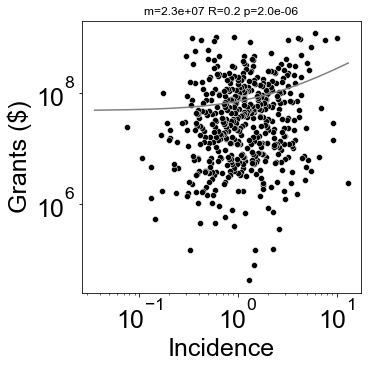

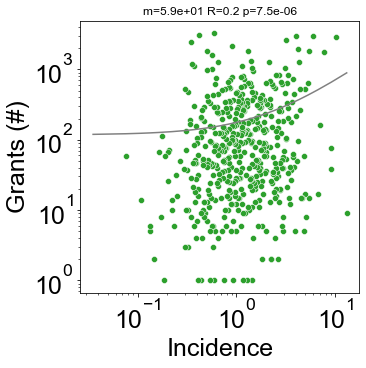

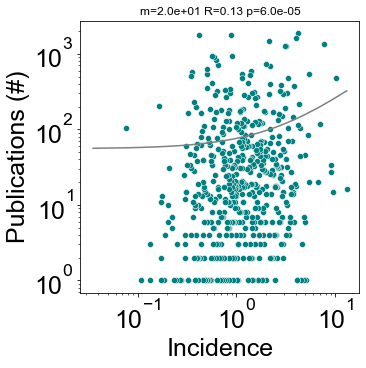

In [13]:
#xy corr plot
ylist=['Grants ($)','Grants (#)','Publications (#)']
xlabel1='Incidence'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
xdat=df_AllData[xlabel1].sort_values(ascending=False)
for il in range(len(ylist)):
    ylabel1=ylist[il]
    ydat=df_AllData[ylabel1].sort_values(ascending=False).iloc[11:]

    overlapindex=[idx for idx in xdat.index if idx in ydat.index]

    xvals=xdat.loc[overlapindex].values
    yvals=ydat.loc[overlapindex].values
    Xinp=sm.add_constant(xvals)
    Yinp=yvals
    model1=sm.OLS(Yinp,Xinp)
    results1=model1.fit()

    yvals_predicted=results1.predict(Xinp)
    plt.figure(figsize=(5,5))
    df_plt=pd.concat([xdat,ydat],axis='columns')
    sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
    plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
    plt.xlabel(xlabel1)
    plt.xscale('log')
    plt.yscale('log')
    fname='Panel1_' if ylabel1 == 'Grants (#)' else 'SupplementaryFigure_' 
    fname=fname+xlabel1+'_vs_'+ylabel1
    plt.plot(xvals,yvals_predicted,color='grey')
#     plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
#     plt.close()
    plt.show()

## Supplementary Figure : bar plots

In [14]:
# Grants ($) and Publications for the most incident genes.
Ngenes=20
CGClist_topepidem=df_Incd_CGC.iloc[:Ngenes].index.tolist()
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
ylist=['Grants ($)','Publications (#)'] #'Grants (#)',

for ylabelname in ylist:
    fig,ax1=plt.subplots(figsize=[11,4])
    df_pubs_grants.loc[CGClist_topepidem].plot.bar(y=ylabelname,color=col_dic[ylabelname],legend=False,ax=ax1)
    plt.ylabel(ylabelname)
    plt.yscale('log')
    fname='SupplementaryFigure_Bar_'+ylabelname
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()

In [15]:
# Mutations Incidence bar plot for top genes by Grants ($) and publications
ylist=['Grants ($)','Publications (#)'] #,'Grants (#)'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
# ylabelname=ylist[3]
Ngenes=20
for ylabelname in ylist:
    fig,ax1=plt.subplots(figsize=[11,4])
    df_barplt=df_AllData.sort_values(by=ylabelname,ascending=False).iloc[:Ngenes]
    df_barplt.plot.bar(y='Incidence',color='k',legend=False,ax=ax1)
    plt.ylabel('Mutation Burden (%)')
    ax1.set_yscale('log')
    fname='SupplementaryFigure_Bar_MutBurden_'+ylabelname
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()

# Supplementary Figure :Gene-Sublists

In [16]:
### Import list of genes in RAS pathway, Kinome, Consensus 1 and 2

dfGA=pd.read_csv(os.path.join(cwd_genelists,'List_Ras_Kinome.txt'),sep='\t') # annotated lists
kinomelist=set([elem for elem in dfGA['Kinome'] if elem is not np.nan])

Raslist=set([elem for elem in dfGA['RAS_Pathway'] if elem is not np.nan])
Raslist=[FindGeneName(igene) for igene in Raslist]
kinomelist=[FindGeneName(igene) for igene in kinomelist]

print(checkindices(Raslist),checkindices(CGClist),checkindices(kinomelist))
for igene in checkindices(Raslist):
    Raslist.remove(igene)
for igene in checkindices(kinomelist):
    kinomelist.remove(igene)
    
kinomelist_CGC=[igene for igene in kinomelist if igene in CGClist]
Raslist_CGC=[igene for igene in Raslist if igene in CGClist]

### Drug Targets list

df_DT=pd.read_excel(os.path.join(cwd_genelists,'drug_list.xlsx'),dtype=str) # Curated List of drug targets

# Process list of gene in both CGC list and are drug targets
def ProcessStr(inpstr):
    outstr=inpstr
    
    removelist=[str('\xa0')] # strings which need to be removed
    for istr in removelist:
        if istr in inpstr:
            outstr=inpstr.replace('\xa0','')
    
    splitlist=['and',';',',',' '] # strings which are joiners
    outstr=[outstr]
    for isplitstr in splitlist:
        outstr=[icol for istr in outstr for icol in istr.split(isplitstr)] # flattended split list
    return outstr

DTlist=list(set([icol for irow in df_DT['target_gene'].dropna().apply(ProcessStr).values for icol in irow]))
DTlist_renamed=[FindGeneName(igene) for igene in DTlist]
DTlist_CGC=[igene for igene in DTlist_renamed if igene in CGClist]

print('# targets:',len(DTlist),', # targets in CGC: ',len(DTlist_CGC))

# How many of the top 20 most funded are also drug targets?
Ngenes=20
list_mostFunded=df_AllData.sort_values(by='Grants ($)',ascending=False).iloc[:Ngenes].index.to_list()
print('Number of targets among top 20 funded genes:',len([igene for igene in list_mostFunded if igene in DTlist_CGC]))
list_mostPublished=df_AllData.sort_values(by='Publications (#)',ascending=False).iloc[:Ngenes].index.to_list()
print('Number of targets among top 20 published genes:',len([igene for igene in list_mostPublished if igene in DTlist_CGC]))

### Transcription factor

df_TF=pd.read_excel(os.path.join(cwd_genelists,'Transcription_Factors_List_S1A_Cell2018_Lambertetal.xlsx'),dtype=str) # List of transcription factors from review:https://doi.org/10.1016/j.cell.2018.01.029

df_TF=df_TF[df_TF['TF']=='Yes']
TFlist=[FindGeneName(igene) for igene in df_TF.Name]
TF_CGClist=list(set([igene for igene in TFlist if igene in CGClist]))

print('TF in drugs targets:', [igene for igene in TFlist if igene in DTlist])

print('TF in drugs targets and CT1:', [igene for igene in TF_CGClist if igene in DTlist_CGC])

###  Jackson labs Transgenic Mice list

df_JAX=pd.read_excel(os.path.join(cwd_genelists,'JAX_Mutant_Mouse_Resource_mtbwi.xlsx'),dtype=str)
df_JAX.dropna(how='all',inplace=True)

ifulllist=[]
for iloc1 in df_JAX.index:
    istr1=str(df_JAX.loc[iloc1,'Strain']).upper()
    igenelist=[igene for igene in CGCaliaslist if igene in istr1]
    ifulllist=ifulllist+[igenelist]
df_JAX.Gene=ifulllist

JAXlist=list(set([ig1 for iglist in df_JAX.Gene for ig1 in iglist]))


JAXlist=[FindGeneName(istr) for istr in JAXlist]
JAX_CGClist=list(set([istr for istr in JAXlist if istr in CGClist]))

###  Jackson labs PDX list

# print(''.join([igene+':MUT\n' for igene in CGClist])) # This command is useful in obtaining a list of PDXes from the jackson lab website.


df_PDX=pd.read_csv(os.path.join(cwd_genelists,'PDXCaseReport_CT1-2022-04-13.csv'),sep=',',comment='#') # obtained from:tumor.informatics.jax.org/mtbwi/pdxLikeMe.do

dropcols=[icol for icol in df_PDX.columns if all(df_PDX[icol].isna())]

df_PDX.drop(columns=dropcols,inplace=True)

PDXlist=[icol.split(' ')[0] for icol in df_PDX.columns if 'X ' in df_PDX[icol].values]
PDXlist=[FindGeneName(igene) for igene in PDXlist]
PDX_CGClist=list(set([igene for igene in PDXlist if igene in CGClist]))

#### Chromatin regulatory complex genes from Nat Genet. 2013 May 5; 45(6): 592–601. doi:10.1038/ng.2628.

df_CRC=pd.read_excel(os.path.join(cwd_genelists,'BAF_Complex_ST4_CRCsubunits_Hargreaves20.xlsx'),dtype=str)

CRC_list=list(set(df_CRC['BAF-complex-subunit'].values.tolist()+df_CRC['Aliases'].dropna().values.tolist()))
CRClist=[FindGeneName(igene) for igene in CRC_list]
CRC_CGClist=list(set([igene for igene in CRClist if igene in CGClist]))

['RASSF10'] True ['CRKRS', 'CAMK1B', 'MAP3K14', 'PRKY', 'CCRK', 'SGK269', 'CABC1']
# targets: 142 , # targets in CGC:  57
Number of targets among top 20 funded genes: 10
Number of targets among top 20 published genes: 12
TF in drugs targets: ['EPAS1', 'MTF1', 'AR', 'ESR1', 'ESR2']
TF in drugs targets and CT1: ['AR', 'EPAS1', 'ESR1']


C:\Users\GM\AppData\Local\Temp/ipykernel_556/2944130990.py:73: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_JAX.Gene=ifulllist


## Supplementary Figure C - gene sublists

In [17]:
fun_remNAgenes=lambda l1:[igene for igene in l1 if igene not in dropnagenes]
boxdic={'CGC':fun_remNAgenes(CGClist),'Drug Targets':fun_remNAgenes(DTlist_CGC),'Kinases':fun_remNAgenes(kinomelist_CGC),'TF':fun_remNAgenes(TF_CGClist),'RAS Pthwy':fun_remNAgenes(Raslist_CGC),'CRC':fun_remNAgenes(CRC_CGClist),'GEMM_JAX':fun_remNAgenes(JAX_CGClist),'PDX':fun_remNAgenes(PDX_CGClist)}

In [18]:
yllist=['Incidence','Grants ($)','Publications (#)']#,'Grants (#)', 'Pubs[tiab]'
for ylabel in yllist:
    allgenes=list(set([irow for icol in boxdic.values() for irow in icol]))
    df_boxplt=pd.DataFrame(index=allgenes,columns=boxdic.keys())
    for iglName in boxdic.keys():
        for igene in boxdic[iglName]:
            df_boxplt.loc[igene,iglName]=df_AllData.loc[igene,ylabel]
    df_boxplt.fillna(np.nan,inplace=True)
    fname='SupplementaryFigure_C_BoxWhsk_'+ylabel
    df_boxplt.to_excel(os.path.join(cwd_res,'Tables',fname+'.xlsx'))
    df_boxplt.boxplot(rot=90)
    plt.xticks(ticks=range(1,len(df_boxplt.columns)+1),labels=[ilb+'('+str(len(boxdic[ilb]))+')' for ilb in df_boxplt.columns])
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.yticks(rotation=90,va='center',size=30)
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()

## Supplementary Figure C - gene sublists statistical analyses

In [19]:
from scipy.stats import mannwhitneyu as mwu

In [20]:
x_label='CGC' # lesser distribution under tested hypothesis  
# y_label='Kinases' # greater distribution under tested hypothesis
for y_label in list(boxdic.keys())[1:-2]+['GEMM_JAX']:
    # identify IDs in list1 that are not present in list2
    x_label_list=boxdic[x_label]
    y_label_list=boxdic[y_label]
    if len(x_label_list)>len(y_label_list):
        x_label_list=[igene for igene in x_label_list if igene not in y_label_list] # update x-label list - when x list is larger
    else:
        y_label_list=[igene for igene in y_label_list if igene not in x_label_list] # update y-label list - when y-list is larger
        # test is neither appropriate not necessary when the two gene lists are nearly the same

    dataset='Publications (#)' # The quantity being compared
    x=df_AllData.loc[x_label_list,dataset].values
    y=df_AllData.loc[y_label_list,dataset].values
    res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
    print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

    dataset='Grants ($)' # The quantity being compared
    x=df_AllData.loc[x_label_list,dataset].values
    y=df_AllData.loc[y_label_list,dataset].values
    res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
    print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

p-value that  Publications (#)  for  CGC  <  Drug Targets :1e-12
p-value that  Grants ($)  for  CGC  <  Drug Targets :2e-14
p-value that  Publications (#)  for  CGC  <  Kinases :8e-10
p-value that  Grants ($)  for  CGC  <  Kinases :4e-10
p-value that  Publications (#)  for  CGC  <  TF :2e-02
p-value that  Grants ($)  for  CGC  <  TF :1e-01
p-value that  Publications (#)  for  CGC  <  RAS Pthwy :6e-16
p-value that  Grants ($)  for  CGC  <  RAS Pthwy :2e-15
p-value that  Publications (#)  for  CGC  <  CRC :8e-01
p-value that  Grants ($)  for  CGC  <  CRC :7e-01
p-value that  Publications (#)  for  CGC  <  GEMM_JAX :2e-20
p-value that  Grants ($)  for  CGC  <  GEMM_JAX :3e-21


In [21]:
x_label='TF' # lesser distribution under tested hypothesis  
y_label='Kinases' # greater distribution under tested hypothesis
x_label_list=boxdic[x_label]
y_label_list=boxdic[y_label]
if len(x_label_list)>len(y_label_list):
    x_label_list=[igene for igene in x_label_list if igene not in y_label_list] # update x-label list - when x list is larger
else:
    y_label_list=[igene for igene in y_label_list if igene not in x_label_list] # update y-label list - when y-list is larger
    # test is neither appropriate not necessary when the two gene lists are nearly the same

dataset='Publications (#)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

dataset='Grants ($)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

p-value that  Publications (#)  for  TF  <  Kinases :5e-05
p-value that  Grants ($)  for  TF  <  Kinases :9e-06


In [22]:
x_label='CRC' # lesser distribution under tested hypothesis  
y_label='CGC' # greater distribution under tested hypothesis
x_label_list=boxdic[x_label]
y_label_list=boxdic[y_label]
if len(x_label_list)>len(y_label_list):
    x_label_list=[igene for igene in x_label_list if igene not in y_label_list] # update x-label list - when x list is larger
else:
    y_label_list=[igene for igene in y_label_list if igene not in x_label_list] # update y-label list - when y-list is larger
    # test is neither appropriate not necessary when the two gene lists are nearly the same

dataset='Publications (#)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

dataset='Grants ($)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

p-value that  Publications (#)  for  CRC  <  CGC :2e-01
p-value that  Grants ($)  for  CRC  <  CGC :3e-01


In [23]:
x_label='PDX' # lesser distribution under tested hypothesis  
y_label='GEMM_JAX' # greater distribution under tested hypothesis
x_label_list=boxdic[x_label]
y_label_list=boxdic[y_label]
if len(x_label_list)>len(y_label_list):
    x_label_list=[igene for igene in x_label_list if igene not in y_label_list] # update x-label list - when x list is larger
else:
    y_label_list=[igene for igene in y_label_list if igene not in x_label_list] # update y-label list - when y-list is larger
    # test is neither appropriate not necessary when the two gene lists are nearly the same

dataset='Publications (#)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

dataset='Grants ($)' # The quantity being compared
x=df_AllData.loc[x_label_list,dataset].values
y=df_AllData.loc[y_label_list,dataset].values
res_mwu=mwu(x,y,alternative='less') # test for a random sample from x distribution being lesser than y distribution half the times samples. 
print('p-value that ',dataset,' for ',x_label,' < ',y_label,f':{res_mwu.pvalue:.0e}')

p-value that  Publications (#)  for  PDX  <  GEMM_JAX :4e-17
p-value that  Grants ($)  for  PDX  <  GEMM_JAX :2e-18


# Supplementary Panels

## Panel 1 is calculated alongside above scatter plots for supplementary figures

## Panel 2: Correlation between NCI Grants (USD) and Mutation Burden

In [24]:
df_Pubmed_AACR=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NCI_NIH+AACR_PM_Data.xlsx'),index_col='Gene name')

print([idx for idx in df_Pubmed_AACR.index if idx!=FindGeneName(idx)])

df_Pubmed_AACR.index=[FindGeneName(idx) for idx in df_Pubmed_AACR.index]

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [25]:
col_dic['Award Amount[title/abstract]']='k'

In [26]:
#xy corr plot
ylabel1='Award Amount[title/abstract]'
xlabel1='Incidence'
xdat=df_AllData[xlabel1].sort_values(ascending=False)
ydat=df_Pubmed_AACR[ylabel1].sort_values(ascending=False)

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)

fig,ax1=plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)

plt.xlabel(xlabel1)
plt.xscale('log')
plt.yscale('log')
rembcksl=lambda str1:str1.split('/')[0]+'_'+str1.split('/')[1]
fname='Panel2_'+xlabel1+'_vs_'+rembcksl(ylabel1)
plt.plot(xvals,yvals_predicted,color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

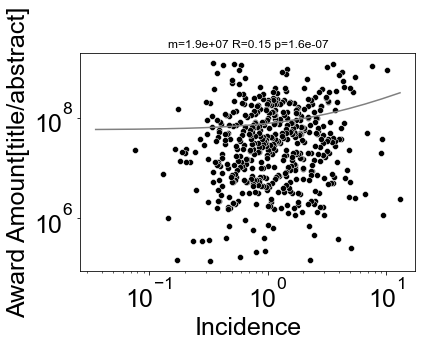

In [27]:
#xy corr plot
ylabel1='Award Amount[title/abstract]'
xlabel1='Incidence'
xdat=df_AllData[xlabel1].sort_values(ascending=False)
ydat=df_Pubmed_AACR[ylabel1].sort_values(ascending=False).iloc[11:]

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)

fig,ax1=plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)

plt.xlabel(xlabel1)
plt.xscale('log')
plt.yscale('log')
rembcksl=lambda str1:str1.split('/')[0]+'_'+str1.split('/')[1]
fname='Panel2_'+xlabel1+'_vs_'+rembcksl(ylabel1)
plt.plot(xvals,yvals_predicted,color='grey')
# plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.show()

### Panel3,4: AACR journals (no cancer keyword) vs mutation burden

In [28]:
col_dic['Pubs[title]']='teal'

In [29]:
#xy corr plot
ylabel1='Pubs[title]'
xlabel1='Incidence'
xdat=df_AllData[xlabel1].sort_values(ascending=False)
ydat=df_Pubmed_AACR[ylabel1].sort_values(ascending=False)

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xdat=xdat.loc[overlapindex]
ydat=ydat.loc[overlapindex]
xvals=xdat.values
yvals=ydat.values

Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)

plt.figure(figsize=(5,5))
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
plt.xlabel(xlabel1)
plt.ylabel(ylabel1+'_AACR')
plt.ylim([1,1500])
plt.xscale('log')
plt.yscale('log')
fname='Panel3_'+xlabel1+'_vs_'+ylabel1+'_AACR'
plt.plot(xvals,yvals_predicted,color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

# Plot residuals
yresd=(yvals-yvals_predicted)
plt.figure(figsize=(5,5))
yresdprop=[(np.nan if yvals[i]==0 else yresd[i]/yvals[i]) for i in range(len(yresd))] #residue proportion
plt.scatter(x=yvals, y=yresdprop,color='tab:blue') # proportional residue shows explicit better fitting of largest values drives the overall fit.
plt.xlabel(ylabel1)
plt.ylabel('Residual Proportions')
plt.xscale('log')
plt.yscale('log')
fname='Panel4_ResidualProportions_AACR'
plt.plot(yvals,[0]*len(yvals),color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()
# Plot residuals
plt.figure(figsize=(5,5))
plt.scatter(x=yvals, y=yresd,color='tab:blue') # proportional residue shows explicit better fitting of largest values drives the overall fit.
plt.xlabel(ylabel1)
plt.ylabel('Pubs (#) Residuals')
plt.xscale('log')
# plt.yscale('log')
fname='Panel4_Residuals_AACR'
plt.plot(yvals,[0]*len(yvals),color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

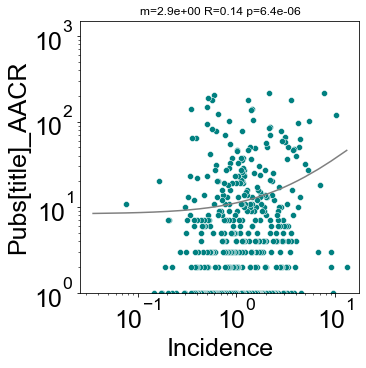

In [30]:
xdat=df_AllData[xlabel1].sort_values(ascending=False)
ydat=df_Pubmed_AACR[ylabel1].sort_values(ascending=False).iloc[11:]

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xdat=xdat.loc[overlapindex]
ydat=ydat.loc[overlapindex]
xvals=xdat.values
yvals=ydat.values

Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)

plt.figure(figsize=(5,5))
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
plt.xlabel(xlabel1)
plt.ylabel(ylabel1+'_AACR')
plt.ylim([1,1500])
plt.xscale('log')
plt.yscale('log')
fname='Panel3_'+xlabel1+'_vs_'+ylabel1+'_AACR'
plt.plot(xvals,yvals_predicted,color='grey')
# plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.show()

In [31]:
'Percent of CGC Genes with <=2 pubs at AACR:',round((sum(df_Pubmed_AACR['Pubs[title]']<=2))/len(CGClist),2)*100

('Percent of CGC Genes with <=2 pubs at AACR:', 49.0)

## Panel 5 (right) Compare the Pubmed counts with that from Pubmed within AACR journals only 

In [32]:
df_Pubmed_AACR=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NCI_NIH+AACR_PM_Data.xlsx'),index_col='Gene name')

print([idx for idx in df_Pubmed_AACR.index if idx!=FindGeneName(idx)])

df_Pubmed_AACR.index=[FindGeneName(idx) for idx in df_Pubmed_AACR.index]

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [33]:
xlabel='Publications (#)'
ylabel='Pubs[title]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Pubmed_AACR[ylabel]

overlapindex=[idx for idx in xdat.index if (idx in ydat.index) and (xdat[idx]>0) and (ydat[idx]>0)]

ydat=ydat[overlapindex]
xdat=xdat[overlapindex]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[xlabel1])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel5_Pubs_AACR_'+xlabel+'_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

## Panel 5 (left) Compare the total grants data with that from NCI grants alone (controlling for non-cancer related grants in the same genes)

In [34]:
df_Grants_NCI=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NCI_NIH+AACR_PM_Data.xlsx'),index_col='Gene name') 
df_Grants_NCI.index=[FindGeneName(idx) for idx in df_Grants_NCI.index]

In [35]:
xlabel='Grants ($)'
ylabel='Award Amount[title/abstract]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Grants_NCI[ylabel]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(ax=ax1,x=xlabel,y=ylabel,data=df_plt,color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12) 
fname='Panel5_'+xlabel+'_vs_'+ylabel.split('/')[0]+ylabel.split('/')[1]
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

## Panel 6 Compare grants with title only searches vs title+abstract.

In [36]:
#xy corr plot
ylabel='Award Amount[title]'
xlabel='Grants ($)'

xdat=df_AllData[xlabel][df_AllData[xlabel]>0].sort_values(ascending=False)

ydat=df_AllData[ylabel][df_AllData[ylabel]>0].sort_values(ascending=False)

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()



yvals_predicted=results1.predict(Xinp)
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(x=xlabel,y=ylabel,data=df_plt,color='k')
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
plt.xlabel(xlabel)
plt.ylabel(ylabel+'_TitleOnly')
plt.xscale('log')
plt.yscale('log')
fname='Panel6_'+xlabel+'_vs_'+ylabel
plt.plot(xvals,yvals_predicted,color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

### Panel 6 right Compare pubs with title only searches vs title+abstract.

In [37]:
#xy corr plot
ylabel='Pubs[tiab]'
xlabel='Publications (#)'

xdat=df_AllData[xlabel][df_AllData[xlabel]>0].sort_values(ascending=False)

ydat=df_AllData[ylabel][df_AllData[ylabel]>0].sort_values(ascending=False)

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()



yvals_predicted=results1.predict(Xinp)
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(x=xlabel,y=ylabel,data=df_plt,color='teal')
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
plt.xlabel(xlabel)
plt.ylabel(ylabel+'_TitleOnly')
plt.xscale('log')
plt.yscale('log')
fname='Panel6_'+xlabel+'_vs_'+ylabel
plt.plot(xvals,yvals_predicted,color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

### Panel 7 Compare the NIH grants data with that from NIH grants which are probed without filtering for the keyword 'cancer' : This checks for how impactful was the effect of excluding grants on each gene that didn't include the word cancer 

In [38]:
df_pubs_grants_NoCan=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NIH+PM_Data_no_cancer.xlsx'),index_col='Gene name')

print([idx for idx in df_pubs_grants_NoCan.index if idx!=FindGeneName(idx)])

df_pubs_grants_NoCan.index=[FindGeneName(idx) for idx in df_pubs_grants_NoCan.index]

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [39]:
xlabel='Grants ($)'
ylabel='Award Amount[title/abstract]'

xdat=df_pubs_grants[xlabel].sort_values(ascending=False)
ydat=df_pubs_grants_NoCan[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel+'_Cancer'
ylabel1=ylabel+'_NoCancer'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')
plt.xlabel(xlabel1)
plt.ylabel(ylabel1)
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel7_NIH_NoCancer_'+xlabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

In [40]:
xlabel='Publications (#)'
ylabel='Pubs[title]'

xdat=df_pubs_grants[xlabel].sort_values(ascending=False)
ydat=df_pubs_grants_NoCan[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel+'_Cancer'
ylabel1=ylabel+'_NoCancer'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='teal')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')
plt.xlabel(xlabel1)
plt.ylabel(ylabel1)
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel7_NoCancer_'+xlabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

### Panel 7_1 (middle and bottom) Compare the NIH grants data with that from NIH grants which are probed filtering for 121 cancer phrases  : This checks for how impactful was the effect of excluding grants on each gene that didn't included keywords other than cancer 

In [41]:
df_pubs_grants_AltCan=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NIH+PM_Data_Cancer_synonyms.xlsx'),index_col='Gene name') 

print([idx for idx in df_pubs_grants_AltCan.index if idx!=FindGeneName(idx)])

df_pubs_grants_AltCan.index=[FindGeneName(idx) for idx in df_pubs_grants_AltCan.index]

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [42]:
# total funding for different sources
'NIH (Billion $):', df_AllData['Grants ($)'].sum()/10**9, 'NCI (Billion $):', df_Pubmed_AACR['Award Amount[title/abstract]'].sum()/10**9,'NIH 121 (Billion $):',  df_pubs_grants_AltCan['Award Amount[title/abstract]'].sum()/10**9

('NIH (Billion $):',
 68.146839966,
 'NCI (Billion $):',
 69.811955315,
 'NIH 121 (Billion $):',
 87.583345306)

In [43]:
# total publications for different sources
'PubMed (Million):', df_AllData['Publications (#)'].sum()/10**6, 'AACR (Million):', df_Pubmed_AACR['Pubs[title]'].sum()/10**6,'PubMed 121 (Million):',  df_pubs_grants_AltCan['Pubs[title]'].sum()/10**6

('PubMed (Million):',
 0.101239,
 'AACR (Million):',
 0.012049,
 'PubMed 121 (Million):',
 0.206583)

In [44]:
xlabel='Grants ($)'
ylabel='Award Amount[title/abstract]'

xdat=df_pubs_grants[xlabel].sort_values(ascending=False)
ydat=df_pubs_grants_AltCan[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel+'_Cancer'
ylabel1=ylabel+'_AltCancer'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')
plt.xlabel(xlabel1)
plt.ylabel(ylabel1)
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel7_1_NIH_AltCancer_'+xlabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()
# plt.show()

In [45]:
xlabel='Publications (#)'
ylabel='Pubs[title]'

xdat=df_pubs_grants[xlabel].sort_values(ascending=False)
ydat=df_pubs_grants_AltCan[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel+'_Cancer'
ylabel1=ylabel+'_AltCancer'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='teal')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')
plt.xlabel(xlabel1)
plt.ylabel(ylabel1)
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel7_1_AltCancer_'+xlabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()
# plt.show()

## Scatter plots

In [64]:
#xy corr plot
df_pubs_grants_AltCan.rename(columns={'Award Amount[title/abstract]':'Grants ($)','Pubs[title]':'Publications (#)'},inplace=True)
ylist=['Grants ($)','Publications (#)']
xlabel1='Incidence'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
xdat=df_AllData[xlabel1].sort_values(ascending=False)
for il in range(len(ylist)):
    ylabel1=ylist[il]
    ydat=(df_pubs_grants_AltCan[ylabel1].sort_values(ascending=False)).iloc[11:]

    overlapindex=[idx for idx in xdat.index if idx in ydat.index]

    xvals=xdat.loc[overlapindex].values
    yvals=ydat.loc[overlapindex].values
    Xinp=sm.add_constant(xvals)
    Yinp=yvals
    model1=sm.OLS(Yinp,Xinp)
    results1=model1.fit()

    yvals_predicted=results1.predict(Xinp)
    plt.figure(figsize=(5,5))
    df_plt=pd.concat([xdat,ydat],axis='columns')
    sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
    plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
    plt.xlabel(xlabel1)
    plt.xscale('log')
    plt.yscale('log')
    fname='Panel7_1_AltCancer_' 
    fname=fname+xlabel1+'_vs_'+ylabel1+'_noTop10'
    plt.plot(xvals,yvals_predicted,color='grey')
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()
#     plt.show()

## Repeat panel 7 scatter without filtering for top 10 

In [65]:
#xy corr plot
df_pubs_grants_AltCan.rename(columns={'Award Amount[title/abstract]':'Grants ($)','Pubs[title]':'Publications (#)'},inplace=True)
ylist=['Grants ($)','Publications (#)']
xlabel1='Incidence'
col_dic={'Grants (#)':'tab:green','Grants ($)':'k','Publications (#)':'teal','Pubs[tiab]':'tab:brown'}
xdat=df_AllData[xlabel1].sort_values(ascending=False)
for il in range(len(ylist)):
    ylabel1=ylist[il]
    ydat=(df_pubs_grants_AltCan[ylabel1].sort_values(ascending=False))

    overlapindex=[idx for idx in xdat.index if idx in ydat.index]

    xvals=xdat.loc[overlapindex].values
    yvals=ydat.loc[overlapindex].values
    Xinp=sm.add_constant(xvals)
    Yinp=yvals
    model1=sm.OLS(Yinp,Xinp)
    results1=model1.fit()

    yvals_predicted=results1.predict(Xinp)
    plt.figure(figsize=(5,5))
    df_plt=pd.concat([xdat,ydat],axis='columns')
    sbn.scatterplot(x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[ylabel1])
    plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
    plt.xlabel(xlabel1)
    plt.xscale('log')
    plt.yscale('log')
    fname='Panel7_1_AltCancer_' 
    fname=fname+xlabel1+'_vs_'+ylabel1
    plt.plot(xvals,yvals_predicted,color='grey')
    fname='Panel7_1_AltCancer_' 
    fname=fname+xlabel1+'_vs_'+ylabel1
    plt.plot(xvals,yvals_predicted,color='grey')
    plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
    plt.close()

### Panel 8 Compare the Pubmed and Grants data for Animal studies with the total counts

In [48]:
df_Animal=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NIH+PM_Data_animal_keywords.xlsx'),index_col='Gene name')

In [49]:
print([idx for idx in df_Animal.index if idx!=FindGeneName(idx)])

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [50]:
df_Animal.index=[FindGeneName(idx) for idx in df_Animal.index]

In [51]:
xlabel='Publications (#)'
ylabel='Pubs[title]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Animal[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel+'_Animal'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[xlabel1])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel8_Animal_'+xlabel+'_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

In [52]:
xlabel='Grants ($)'
ylabel='Award Amount[title/abstract]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Animal[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel+'_Animal'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel8_Animal_'+xlabel+'_'+ylabel.split('/')[0]+ylabel.split('/')[1]
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

### Panel 9 Compare the Pubmed and Grants data with and without alias gene names included in searches

In [53]:
df_NoSyn=pd.read_excel(os.path.join(cwd_input_matrices,'controls','NIH+PM_Data_no_synonyms.xlsx'),index_col='Gene name')

In [54]:
print([idx for idx in df_NoSyn.index if idx!=FindGeneName(idx)])

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [55]:
df_NoSyn.index=[FindGeneName(idx) for idx in df_NoSyn.index]

In [56]:
xlabel='Incidence'
ylabel='Award Amount[title/abstract]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_NoSyn[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel+'_NoSyn'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel9_NoSyn_'+xlabel+'_'+ylabel.split('/')[0]+ylabel.split('/')[1]
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

In [57]:
xlabel='Incidence'
ylabel='Pubs[title]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_NoSyn[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel+'_NoSyn'
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='teal')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
# plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel9_NoSyn_'+xlabel+'_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

### Panel 10 Compare the Pubmed counts with that from Pubmed within US publishers only.

In [58]:
df_Pubmed_US=pd.read_excel(os.path.join(cwd_input_matrices,'controls','PM_Data_USA.xlsx'),index_col='Gene name')

In [59]:
print([idx for idx in df_Pubmed_US.index if idx!=FindGeneName(idx)])

['CARS', 'FGFR1OP', 'H3F3A', 'H3F3B', 'HIST1H3B', 'HIST1H4I']


In [60]:
df_Pubmed_US.index=[FindGeneName(idx) for idx in df_Pubmed_US.index]

In [61]:
xlabel='Publications (#)'
ylabel='Pubs[title]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Pubmed_US[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[xlabel1])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel10_Pubs_US_'+xlabel+'_'+ylabel
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

In [62]:
xlabel='Pubs[tiab]'
ylabel='Pubs[title/abstract]'

xdat=df_AllData[xlabel].sort_values(ascending=False)
ydat=df_Pubmed_US[ylabel].loc[xdat.index]

fig, ax1 = plt.subplots()
df_plt=pd.concat([xdat,ydat],axis='columns')
xlabel1=xlabel
ylabel1=ylabel
df_plt.columns=[xlabel1,ylabel1]
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color=col_dic[xlabel])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(min(ydat[ydat>0]),max(ydat))

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)
plt.plot(xvals,yvals_predicted,color='grey')

plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)
fname='Panel10_Pubs_US_'+xlabel+'_'+ylabel.split('/')[0]+ylabel.split('/')[1]
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()

## Panel 11: Correlation between Grants (USD) and publications (#)

In [63]:
#xy corr plot
ylabel1='Grants ($)'
xlabel1='Publications (#)'
xdat=df_AllData[xlabel1].sort_values(ascending=False)
ydat=df_AllData[ylabel1].sort_values(ascending=False)

overlapindex=[idx for idx in xdat.index if idx in ydat.index]

xvals=xdat.loc[overlapindex].values
yvals=ydat.loc[overlapindex].values
Xinp=sm.add_constant(xvals)
Yinp=yvals
model1=sm.OLS(Yinp,Xinp)
results1=model1.fit()

yvals_predicted=results1.predict(Xinp)

fig,ax1=plt.subplots(figsize=(5,5))
df_plt=pd.concat([xdat,ydat],axis='columns')
sbn.scatterplot(ax=ax1,x=xlabel1,y=ylabel1,data=df_plt,color='tab:blue')
plt.title('m='+str(f'{results1.params[1]:.1e}')+' R='+str(round(np.sqrt(results1.rsquared),2))+' p='+str(f'{results1.pvalues[0]:.1e}'),size=12)

plt.xlabel(xlabel1)
plt.xscale('log')
plt.yscale('log')
fname='Panel11_'+xlabel1+'_vs_'+ylabel1
plt.plot(xvals,yvals_predicted,color='grey')
plt.savefig(os.path.join(cwd_res,fname+'.png'),bbox_inches='tight')
plt.close()